### Importing Libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Reading Data through pandas

In [9]:
df = pd.read_csv("iris.csv")
df = df.iloc[:,1:]

### Splittig Dataset into X and y (where X stands for features and y stands for tag) 

In [11]:
y = df.iloc[:100,4].values
y = np.where(y=='Iris-setosa',0,1)

In [12]:
X = df.iloc[:100,[0,2]].values

### Main Adaline Algorithm (Full Batch Gradient Descent)

In [18]:
class AdalineGD:
    def __init__(self,eta=0.1,n_iter=50,random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self,X,y):
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0.0,scale=0.01,size=X.shape[1])
        self.b = np.float64(0)
        self.losses = []

        for e in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y-output)
            self.w += self.eta*(X.T.dot(errors))/X.shape[0]
            self.b += self.eta*(errors.mean())
            loss = (errors**2).mean()
            self.losses.append(loss)
        return self

    def net_input(self,X):
        return np.dot(X,self.w) + self.b

    def activation(self,X):
        return X

    def predict(self,X):
        return np.where(self.activation(self.net_input(X))>=0.4,1,0)        

### Plotting Errors vs Epochs for eta=0.1 ad eta=0.0001

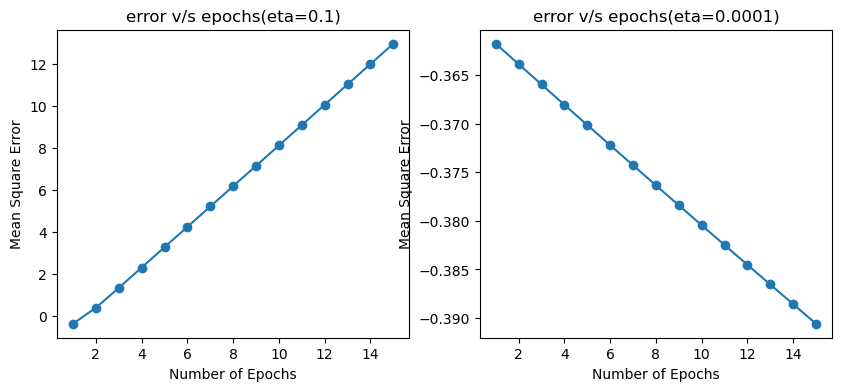

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ada1 = AdalineGD(n_iter=15,eta=0.1).fit(X,y)
ax[0].plot(range(1,len(ada1.losses)+1),np.log10(ada1.losses),marker='o')
ada2 = AdalineGD(n_iter=15,eta=0.0001).fit(X,y)
ax[1].plot(range(1,len(ada2.losses)+1),np.log10(ada2.losses),marker='o')
ax[0].set_title("error v/s epochs(eta=0.1)")
ax[1].set_title("error v/s epochs(eta=0.0001)")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Mean Square Error")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Mean Square Error")
plt.show()

### Standarizing data for Early convergence

In [23]:
mean,std = np.mean(X),np.std(X)
X = (X-mean)/std

### Plotting Errors vs Epochs(with Standarization)

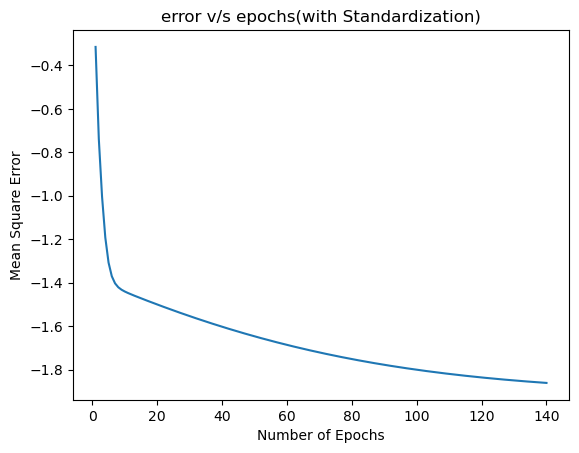

In [26]:
ada3 = AdalineGD(n_iter=140,eta=0.5).fit(X,y)
plt.plot(range(1,len(ada3.losses)+1),np.log10(ada3.losses))
plt.title("error v/s epochs(with Standardization)")
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Square Error")
plt.show()

### Decision Region class for more clear classsification 

In [30]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Step 1: Define colors and markers
    markers = ('o', 's', '^', 'v', '<')  # Different shapes for each class
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')  # Background colors
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Step 2: Create a grid of points
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # Range for feature 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Range for feature 2
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    lab = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1,xx2,lab,alpha=0.3,cmap=cmap)

    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl,0],X[y==cl,1],alpha=0.8,c=colors[idx],label=f"Class {cl}",edgecolor='black')
    

### Plotting Decision Region 

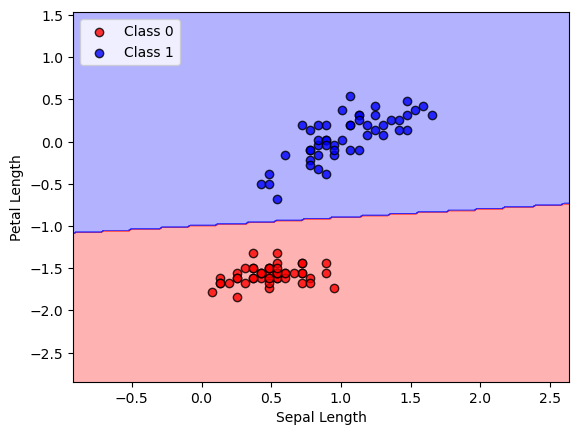

In [33]:
plot_decision_regions(X,y,classifier=ada3)
plt.xlabel("Sepal Length")
plt.ylabel("Petal Length")
plt.legend(loc='upper left')
plt.show()

### Main Adaline Algorithm (Stochastic Full Batch Gradient Descent)

In [58]:
class AdalineSGD:
    def __init__(self,n_iter=10,eta=0.01,shuffle=True,random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.W_intialized = False

    def intialize_weights(self,m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w = self.rgen.normal(loc=0.0,scale=0.01,size=m)
        self.b = np.float64(0)
        self.W_intialized = True

    def update_weights(self,xi,target):
        output = self.activation(self.net_input(xi))
        error = (target-output)
        self.w += self.eta*xi*error*2.0
        self.b += self.eta*error*2.0
        loss = error**2
        return loss

    def net_input(self,X):
        return np.dot(X,self.w) + self.b

    def activation(self,X):
        return X

    def predict(self,X):
        return np.where(self.activation(self.net_input(X))>=0.5,1,0)

    def Shuffle(self,X,y):
        r = self.rgen.permutation(len(y))
        return X[r],y[r]

    def fit(self,X,y):
        self.intialize_weights(X.shape[1])
        self.losses = []
        for i in range(self.n_iter):
            if self.shuffle:
                X,y = self.Shuffle(X,y)
            losses = []
            for xi,target in zip(X,y):
                losses.append(self.update_weights(xi,target))
            avg_loss = np.mean(losses)
            self.losses.append(avg_loss)
        return self

    def partial_fit(self,X,y):
        if not self.W_intialized:
            self.intialize_weights(X.shape[1])
        if y.ravel().shape[0]>1:
            for xi,target in zip(X,y):
                self.update_weights(xi,target)
        else:
            self.update_weights(X,y)

        return self

### Training Adaline Algorithm (Stochastic Full Batch Gradient Descent)

In [61]:
adas = AdalineSGD(n_iter=40,eta=0.01,random_state=100)
adas.fit(X,y)

### Plotting Decision Region for Adaline Algorithm (Stochastic Full Batch Gradient Descent)

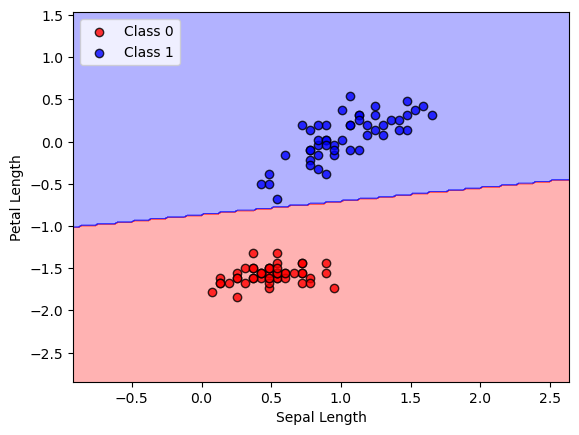

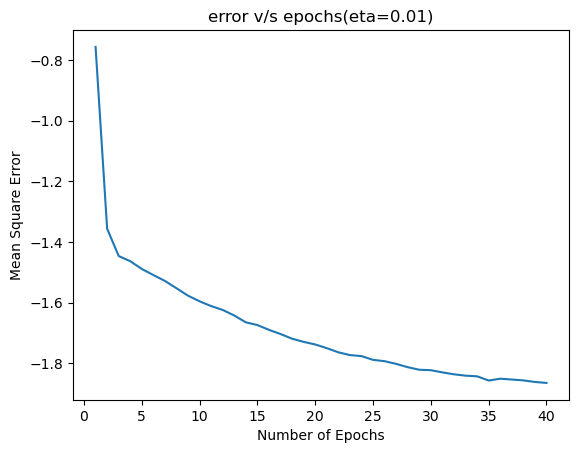

In [67]:
plot_decision_regions(X,y,classifier=adas)
plt.xlabel("Sepal Length")
plt.ylabel("Petal Length")
plt.legend(loc='upper left')
plt.show()
plt.tight_layout
plt.plot(range(1,len(adas.losses)+1),np.log10(adas.losses))
plt.title("error v/s epochs(eta=0.01)")
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Square Error")
plt.show()